## Word Embeddings and T-SNE exercise
We will work with job ads from job.ch. A dataset of English job ads is provided.

The goal of this exercise will be to develop a working understanding of Word2vec and use t-sne as a way to analyze word embeddings

Like any classical NLP task the steps in this analysis will be

- Clean data
- Build a corpus
- Train word2vec
- Visualize using t-sne

In [49]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os

from sklearn.manifold import TSNE

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir('/Users/patrickrs/Documents/GitLab/patrick-steiner/Exercises')

data = pd.read_csv('/Users/patrickrs/Documents/Gitlab/patrick-steiner/Exercises/data/job_ads_eng.csv')  # .sample(50000, random_state=23)
data.head()

,Keywords,Job title,Date published,Alive until,Company name,Location,Company type,Contract type,Occupation,Job rank,Content,Industry,Official website,Canton initials,Canton name
0,ICT System Engineer,System Engineer,2019-05-27 00:00:00,2019-06-05 00:00:00,Harvey Nash AG,Zürich,Consultants,Unlimited employment,100,Employee,System EngineerJob Description Overview of b...,"Recruitment agency, Staffing",http://www.harveynash.com/ch,ZH,Zurich
1,Automation Engineer,Automation Engineer with DeltaV,2019-04-23 00:00:00,2019-05-03 00:00:00,Spring Professional Engineering,Sion,Consultants,Unlimited employment,100,Position with responsibilities,Ihre Herausforderung You plan and implement A...,"Recruitment agency, Staffing",https://www.springprofessional.ch/,VS,Valais
2,Development Engineer,Junior Development Engineer 100% (m/f/d),2019-05-08 00:00:00,2019-05-24 00:00:00,Zentra AG Ihr Jobprofi,Canton of Zug,Consultants,Unlimited employment,Temporary,Position with responsibilities,Since 1989 - more than a quarter of a centur...,"Recruitment agency, Staffing",http://www.zentra.ch,ZG,Zug
3,Contract Analyst,Contract & Commercial Manager,2019-06-14 00:00:00,2019-06-24 00:00:00,Huawei Technologies Switzerland AG,Dübendorf ZH,Large-scale entreprises,Unlimited employment,100,Position with responsibilities,Huawei is a leading global provider of informa...,"Information technology, Telecom.",http://www.huawei.com/,ZH,Zurich
4,Executive Assistant,Executive Assistant 100 %,2019-06-19 00:00:00,2019-06-24 00:00:00,Habasit AG,Reinach,Small and medium-sized enterprises,Unlimited employment,100,Employee,Executive Assistant 100 %Habasit is an interna...,Industry various,http://www.habasit.com,BL,Basel


In [10]:
#%debug
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words('english')

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = re.sub("\s\s+", " ", sentence)
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data[data['Content'] == data['Content']]  # removes nan since nan == nan -> False
    
    for col in ['Content']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

data = clean_dataframe(data)
data.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Keywords,Job title,Date published,Alive until,Company name,Location,Company type,Contract type,Occupation,Job rank,Content,Industry,Official website,Canton initials,Canton name
0,ICT System Engineer,System Engineer,2019-05-27 00:00:00,2019-06-05 00:00:00,Harvey Nash AG,Zürich,Consultants,Unlimited employment,100,Employee,system engineerjob description overview busine...,"Recruitment agency, Staffing",http://www.harveynash.com/ch,ZH,Zurich
1,Automation Engineer,Automation Engineer with DeltaV,2019-04-23 00:00:00,2019-05-03 00:00:00,Spring Professional Engineering,Sion,Consultants,Unlimited employment,100,Position with responsibilities,ihre herausforderung plan implement automation...,"Recruitment agency, Staffing",https://www.springprofessional.ch/,VS,Valais
2,Development Engineer,Junior Development Engineer 100% (m/f/d),2019-05-08 00:00:00,2019-05-24 00:00:00,Zentra AG Ihr Jobprofi,Canton of Zug,Consultants,Unlimited employment,Temporary,Position with responsibilities,since 1989 quarter century zentra ag stands r...,"Recruitment agency, Staffing",http://www.zentra.ch,ZG,Zug
3,Contract Analyst,Contract & Commercial Manager,2019-06-14 00:00:00,2019-06-24 00:00:00,Huawei Technologies Switzerland AG,Dübendorf ZH,Large-scale entreprises,Unlimited employment,100,Position with responsibilities,huawei leading global provider information com...,"Information technology, Telecom.",http://www.huawei.com/,ZH,Zurich
4,Executive Assistant,Executive Assistant 100 %,2019-06-19 00:00:00,2019-06-24 00:00:00,Habasit AG,Reinach,Small and medium-sized enterprises,Unlimited employment,100,Employee,executive assistant 100 habasit international ...,Industry various,http://www.habasit.com,BL,Basel


In [13]:
data[data['Job title'].str.contains('Data')]['Content'].values[0]

'reporting specialist data analyst business intelligence specialist experis currently search experienced business intelligence specialist client leading global company within financial services industry urgently looking experienced business intelligence specialist start immediately right skillset start immediately read apply responsibilities include limited analyze internal reports liaise internal external stakeholders documentation create data reports based oraclesql qlikview business objects one primary clients implement reports dashboards manage stakeholders reviewfeedback sessions iterative development process convert business requirements processes implementation designs reports decide right path deployment create best practices around business intelligence solution profile 3 years relevant experience data technology ideally background within financial services industry experience creating content bi tool eg qlikview business objects prevero ability organize manage stakeholders st

In [45]:
#TO DO: complete the build_corpus function following the description
        #output example: [[''overview', 'business', 'area', 'project', 'resource'], ['work', 'strategic','programs']]
#nltk.download('punkt')
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for content in data['Content']:
        corpus_temp = nltk.word_tokenize(content)
        corpus.append(corpus_temp)
    return corpus

corpus = build_corpus(data)              
corpus[:1]

[['system',
  'engineerjob',
  'description',
  'overview',
  'business',
  'area',
  'project',
  'resource',
  'work',
  'strategic',
  'programs',
  'enterprise',
  'services',
  'department',
  'entire',
  'chief',
  'technology',
  'office',
  'within',
  'bank',
  'key',
  'deliveries',
  'based',
  'servicenow',
  'platform',
  'midserver',
  'infrastructure',
  'consists',
  'configuration',
  'management',
  'database',
  'cmdb',
  'multiple',
  'automatic',
  'semiautomatic',
  'integrations',
  'various',
  'tools',
  'applications',
  'key',
  'responsibilities',
  'exciting',
  'opportunity',
  'lead',
  'servicenow',
  'data',
  'integration',
  'engineering',
  'stream',
  'including',
  'development',
  'maintenance',
  'servicenow',
  'midserver',
  'infrastructure',
  'executing',
  'changes',
  'analysis',
  'incidents',
  'problem',
  'tickets',
  'role',
  'includes',
  'deep',
  'troubleshooting',
  'complex',
  'issues',
  'code',
  'level',
  'open',
  'position

In [47]:
corpus[0]

['system',
 'engineerjob',
 'description',
 'overview',
 'business',
 'area',
 'project',
 'resource',
 'work',
 'strategic',
 'programs',
 'enterprise',
 'services',
 'department',
 'entire',
 'chief',
 'technology',
 'office',
 'within',
 'bank',
 'key',
 'deliveries',
 'based',
 'servicenow',
 'platform',
 'midserver',
 'infrastructure',
 'consists',
 'configuration',
 'management',
 'database',
 'cmdb',
 'multiple',
 'automatic',
 'semiautomatic',
 'integrations',
 'various',
 'tools',
 'applications',
 'key',
 'responsibilities',
 'exciting',
 'opportunity',
 'lead',
 'servicenow',
 'data',
 'integration',
 'engineering',
 'stream',
 'including',
 'development',
 'maintenance',
 'servicenow',
 'midserver',
 'infrastructure',
 'executing',
 'changes',
 'analysis',
 'incidents',
 'problem',
 'tickets',
 'role',
 'includes',
 'deep',
 'troubleshooting',
 'complex',
 'issues',
 'code',
 'level',
 'open',
 'position',
 'responsibility',
 'subject',
 'matter',
 'expert',
 'lead',
 'poin

## Word2Vec

In [148]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
model.wv['python']

array([ 1.2893044 ,  1.4573241 ,  0.94355637,  2.7920582 ,  3.1239839 ,
        2.7951488 , -2.4830546 , -2.966492  , -2.6963632 ,  3.3751469 ,
        2.2312038 , -0.5356949 , -0.09491518,  2.1283789 , -0.0975888 ,
        0.42341468,  1.22097   , -0.33105618, -1.6144719 ,  2.1806414 ,
        0.98642606, -5.068295  ,  1.3898977 ,  1.0241985 , -2.4761343 ,
       -2.9404578 ,  1.3266603 ,  2.568594  , -0.43853185,  2.0280724 ,
        1.2469305 ,  0.6912046 , -2.0092402 , -4.6750455 ,  3.5519845 ,
       -3.759406  , -0.07224364, -1.3794186 , -0.10521476, -0.32586312,
        1.0763836 ,  0.9188923 ,  0.18892118,  1.2355732 ,  3.9759579 ,
        3.6689634 , -2.675376  ,  1.9052887 , -2.161946  , -0.46584556,
       -0.6956283 , -1.9925106 ,  0.758098  ,  0.3330714 ,  0.97693914,
        3.9456282 ,  1.2341672 , -0.2756741 ,  0.49004284, -3.3248718 ,
        0.53194845, -0.01767476, -4.1470184 ,  1.1330876 ,  1.3787813 ,
       -1.4024493 ,  3.8550782 ,  1.9470569 , -0.07952899,  2.33

In [51]:
model

## t-sne plot

In [146]:
#TO DO: Plot the word corpus in a two dimensional plane using dimensionality reduction techniques
def tsne_plot(model, wordlist = []):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    if not wordlist: # if wordlist empty
        wordlist = model.wv.vocab

    for word in wordlist:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=43)
    new_values = tsne_model.fit_transform(tokens)

    x = list(zip(*new_values))[0] # first column of list of lists new_values
    y = list(zip(*new_values))[1] # second column of list of lists new_values

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


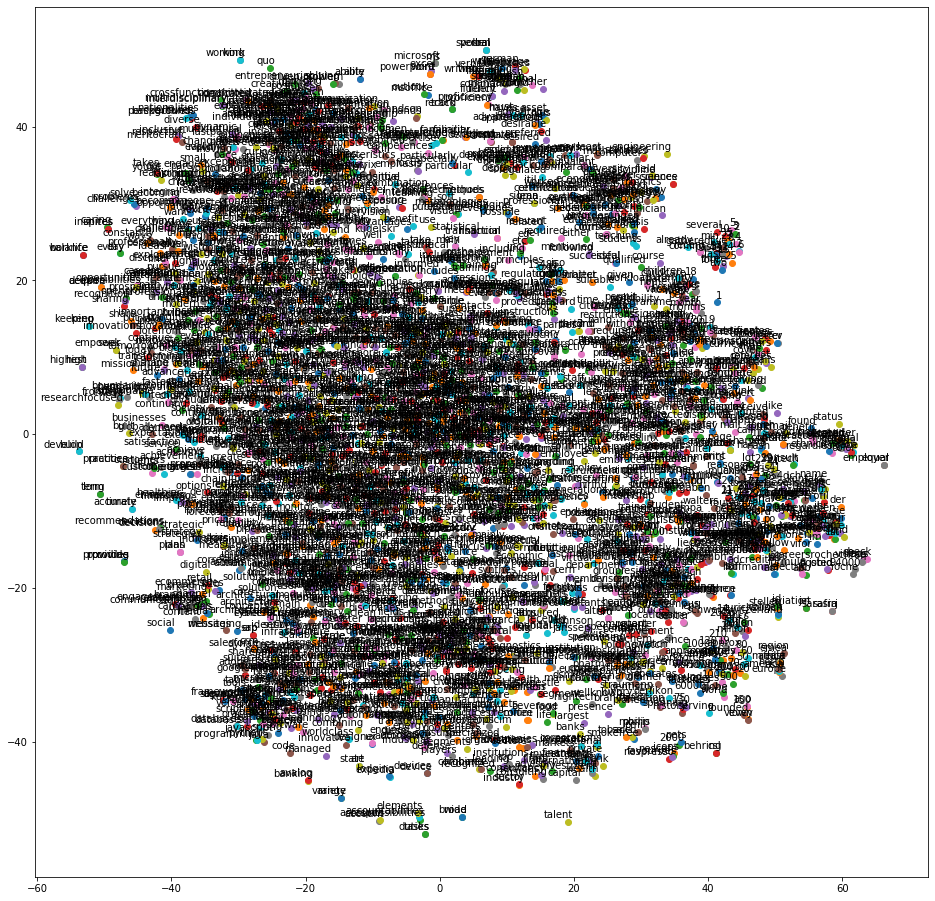

In [147]:
tsne_plot(model)

## More model

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


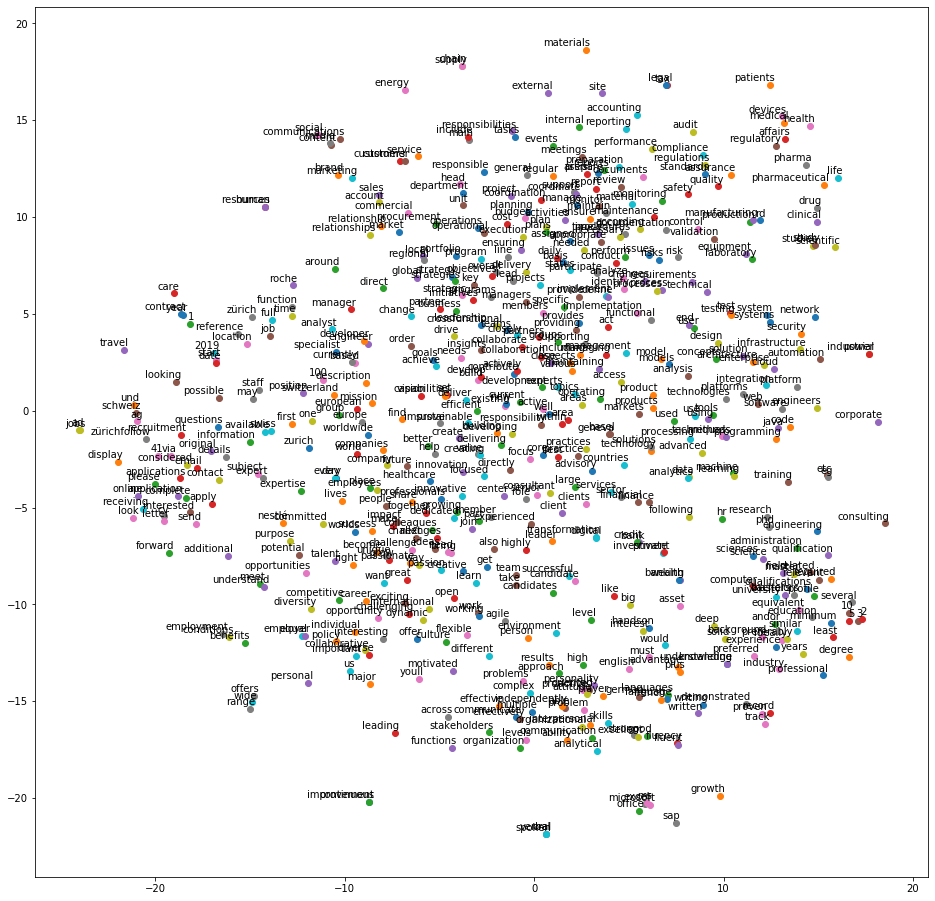

In [104]:
# A more selective model
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=1000, workers=4)
tsne_plot(model)

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


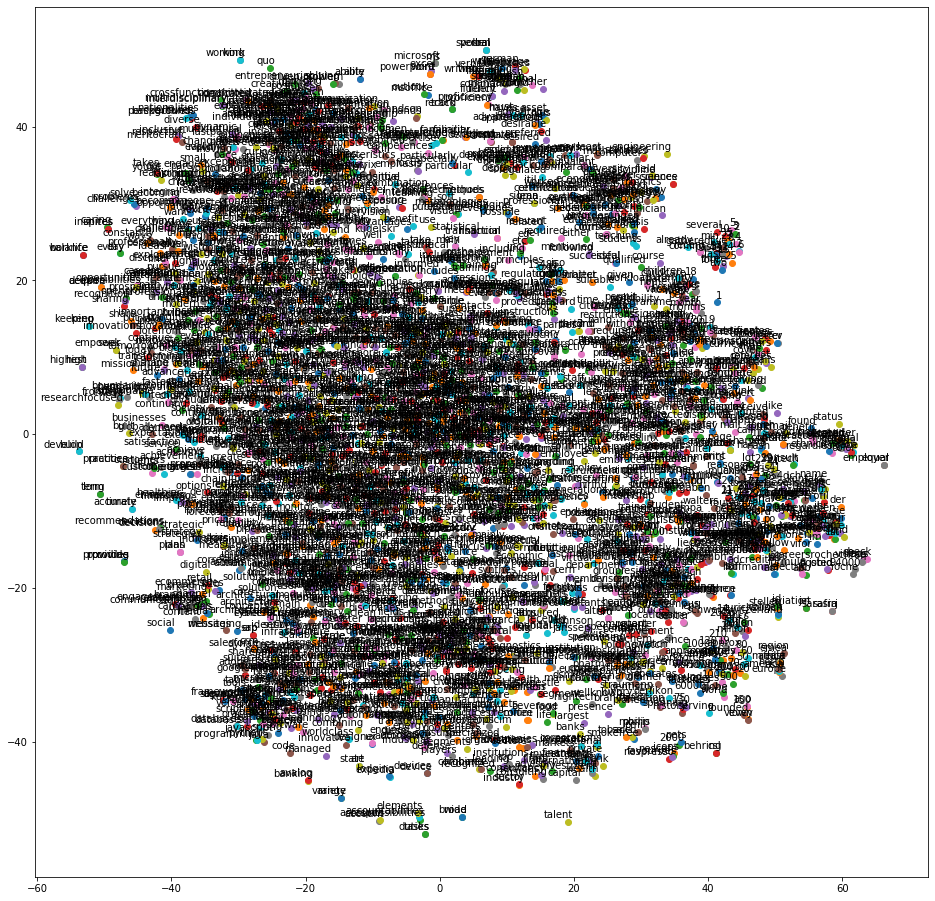

In [145]:
# A less selective model
model = word2vec.Word2Vec(corpus, size=100, window=5, min_count=100, workers=4)
tsne_plot(model)

## Let's find some similar words to our query

In [179]:
model = word2vec.Word2Vec(corpus, size=100, window=25, min_count=50, workers=1, seed = 43)
model.most_similar(search_word, topn=10)

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('programming', 0.9271986484527588),
 ('scala', 0.8143048882484436),
 ('coding', 0.7976663112640381),
 ('tensorflow', 0.7873727083206177),
 ('ruby', 0.7848045825958252),
 ('sql', 0.779326319694519),
 ('c', 0.7755152583122253),
 ('git', 0.7752197980880737),
 ('matlab', 0.7739663124084473),
 ('relational', 0.7679723501205444)]

In [180]:
model = word2vec.Word2Vec(corpus, size=100, window=25, min_count=50, workers=2, seed = 43)
model.most_similar(search_word, topn=10)

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('programming', 0.927931547164917),
 ('scala', 0.812184751033783),
 ('coding', 0.7933956384658813),
 ('tensorflow', 0.782252311706543),
 ('matlab', 0.7778056263923645),
 ('ruby', 0.7761358022689819),
 ('git', 0.7754651308059692),
 ('sql', 0.7746626734733582),
 ('c', 0.7743160128593445),
 ('relational', 0.771130383014679)]

In [183]:
model = word2vec.Word2Vec(corpus, size=100, window=25, min_count=50, workers=3, seed = 43)
model.most_similar(search_word, topn=10)

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('programming', 0.9163911938667297),
 ('scala', 0.8263909816741943),
 ('objectoriented', 0.8041536211967468),
 ('sql', 0.7888497114181519),
 ('relational', 0.7797284126281738),
 ('coding', 0.7785366773605347),
 ('matlab', 0.7684651613235474),
 ('c', 0.7671185731887817),
 ('git', 0.7645100355148315),
 ('r', 0.763306200504303)]

In [184]:
model = word2vec.Word2Vec(corpus, size=100, window=25, min_count=50, workers=4, seed = 43)
model.most_similar(search_word, topn=10)

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('programming', 0.9098771214485168),
 ('scala', 0.8143119812011719),
 ('ruby', 0.7932267189025879),
 ('coding', 0.7846978306770325),
 ('matlab', 0.7811440825462341),
 ('sql', 0.7782909870147705),
 ('tensorflow', 0.7725436687469482),
 ('r', 0.7679963111877441),
 ('objectoriented', 0.7670422792434692),
 ('relational', 0.7637740969657898)]

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


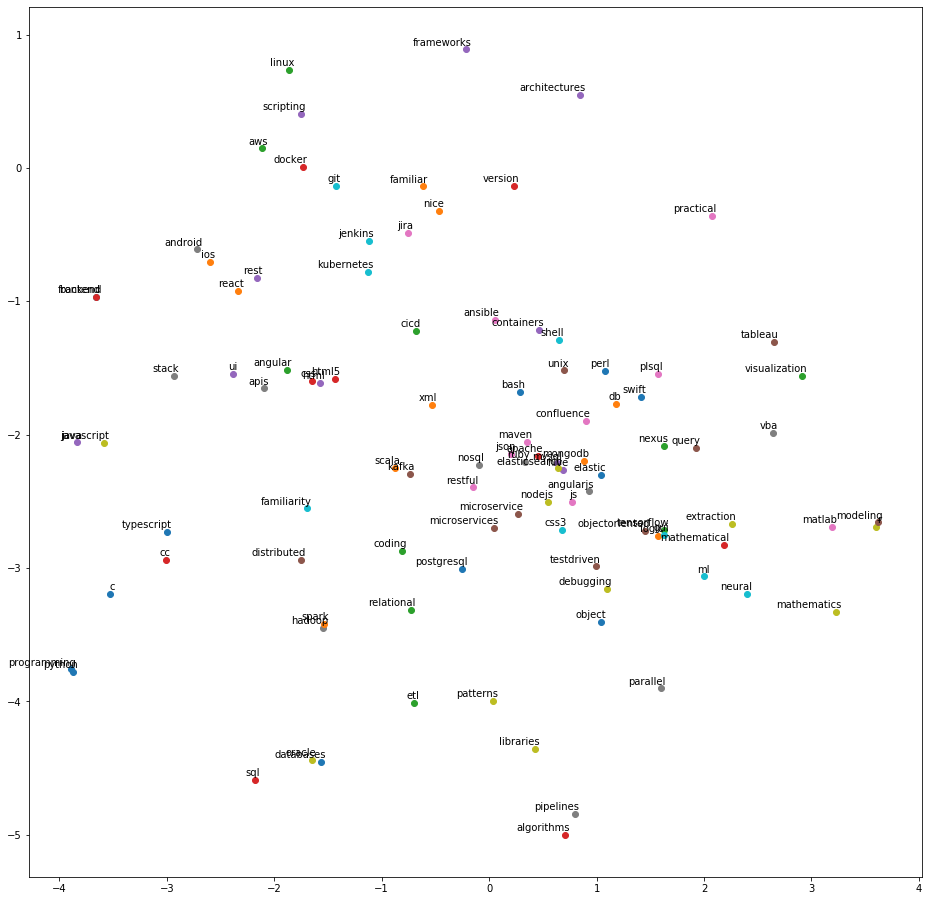

In [155]:
# TODO: Select a word and plot the words most similiar to it

search_word = 'python'
m_similar = model.most_similar(search_word, topn=100)

wordlist = [word[0] for word in m_similar]
# add the word itself
wordlist.append(search_word)

# plot the selected word + the most similiar ones
tsne_plot(model, wordlist)



In [171]:
search_word = 'python'
m_similar = model.most_similar(search_word, topn=100)

wordlist = [word[0] for word in m_similar]

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


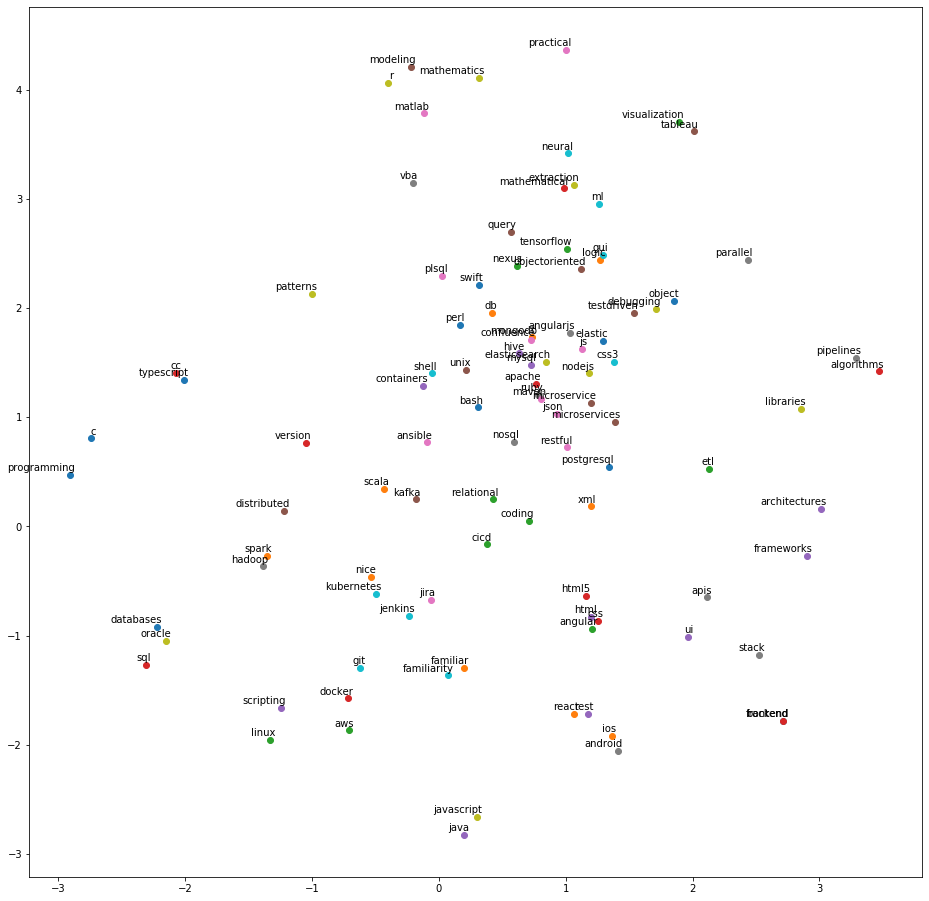

In [172]:
#TO DO: Plot the word corpus in a two dimensional plane using dimensionality reduction techniques

    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    if not wordlist: # if wordlist empty
        wordlist = model.wv.vocab

    for word in wordlist:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=43)
    new_values = tsne_model.fit_transform(tokens)

    x = list(zip(*new_values))[0] # first column of list of lists new_values
    y = list(zip(*new_values))[1] # second column of list of lists new_values

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()